In [38]:
# Yitian block
import os
import sys
sys.path.append("..")

import numpy as np
import healpy as hp

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import jax.scipy.optimize as optimize
from jax.scipy.stats.multivariate_normal import logpdf
from jax.example_libraries import stax

import optax
import numpyro
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI, Trace_ELBO, autoguide, TraceMeanField_ELBO
from numpyro.infer.elbo import Trace_ELBO_2
from numpyro.infer.reparam import NeuTraReparam
from numpyro.infer import MCMC, NUTS
from numpyro.contrib.tfp.mcmc import ReplicaExchangeMC
from tensorflow_probability.substrates import jax as tfp

from utils import create_mask as cm
from utils.sph_harm import Ylm
from utils.map_utils import to_nside

from templates.rigid_templates import EbinTemplate, Template, BulgeTemplates
from templates.variable_templates import NFWTemplate, LorimerDiskTemplate
from likelihoods.pll_jax import log_like_poisson

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../utils/matplotlibrc')

In [39]:
print(os.system('pwd'))

/data/edr76/gce-prob-prog-ed-v0.3/new_dataset
0


In [40]:
pib_temp = np.load("../data/fermi_data_573w/fermi_data_128/template_Opi.npy")
ics_temp = np.load("../data/fermi_data_573w/fermi_data_128/template_Oic.npy")

# artificially increase the number of bins
pib_temp_fin = np.tile(pib_temp, (40,1))
ics_temp_fin = np.tile(ics_temp, (40,1))

# save summed templates
np.save("../data/fermi_data_573w/ebin_128/gceNNopibrem-ultracleanveto-bestpsf.npy", pib_temp_fin)
np.save("../data/fermi_data_573w/ebin_128/gceNNoics-ultracleanveto-bestpsf.npy", ics_temp_fin)

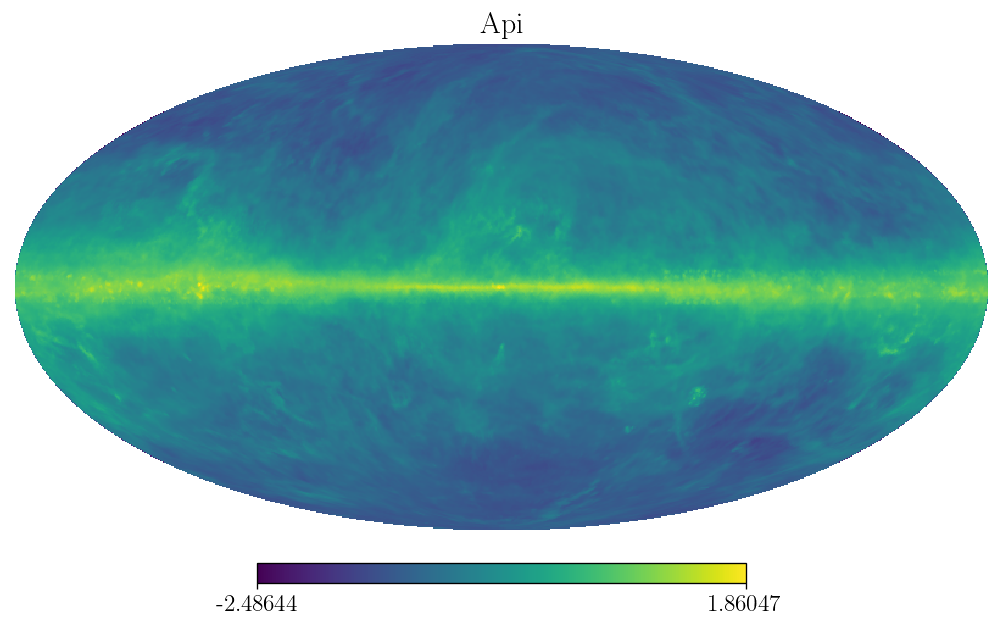

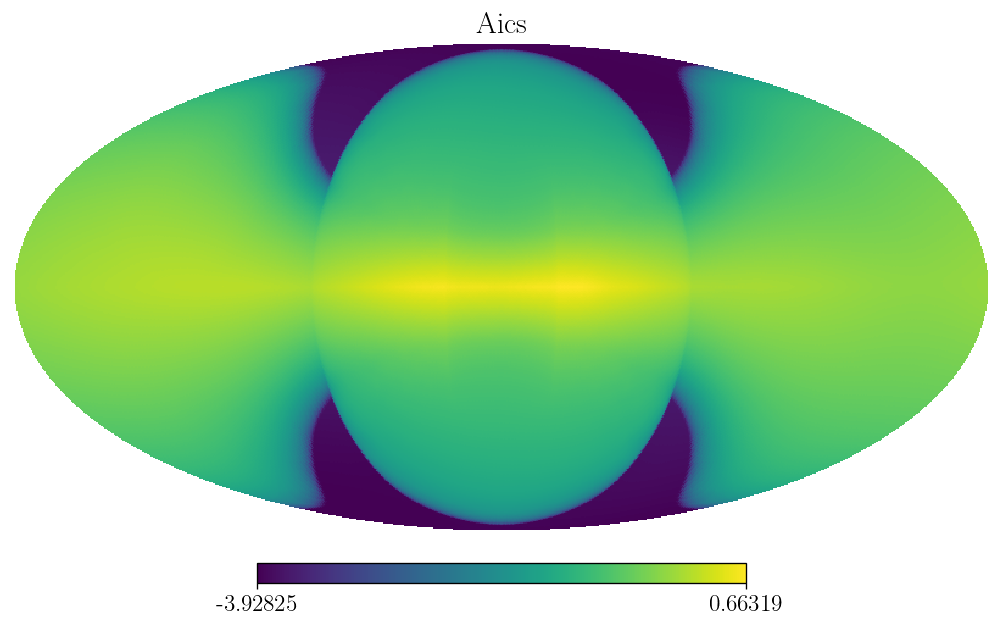

In [41]:
hp.mollview(np.log10(pib_temp), title="Api")
hp.mollview(np.log10(ics_temp), title="Aics")

In [42]:
pib_temp_o = np.load("../data/fermi_data_573w/ebin_128/gceNNopibrem-ultracleanveto-bestpsf.npy")
ics_temp_o = np.load("../data/fermi_data_573w/ebin_128/gceNNoics-ultracleanveto-bestpsf.npy")

pib_temp_a = np.load("../data/fermi_data_573w/ebin_128/gceNNapibrem-ultracleanveto-bestpsf.npy")
ics_temp_a = np.load("../data/fermi_data_573w/ebin_128/gceNNaics-ultracleanveto-bestpsf.npy")

pib_temp_f = np.load("../data/fermi_data_573w/ebin_128/gceNNfpibrem-ultracleanveto-bestpsf.npy")
ics_temp_f = np.load("../data/fermi_data_573w/ebin_128/gceNNfics-ultracleanveto-bestpsf.npy")

In [43]:
pib_temp.shape

(786432,)

In [44]:
from utils import create_mask as cm
from utils import ed_fcts as ef

nside = 128
mask_roi_b = 2.
mask_roi_r_outer = 25.

mask_roi_arr = np.asarray([
    cm.make_mask_total(
        nside=128,
        band_mask=True,
        band_mask_range=mask_roi_b,
        mask_ring=True,
        inner=0,
        outer=mask_roi_r_outer,
        # custom_mask=mask_ps_at_eng
    )
])

mask_roi = mask_roi_arr[0]
pib_temp_hp = ef.convert_masked_array_to_hp_array(pib_temp[~mask_roi], mask_roi, nside=128)
ics_temp_hp = ef.convert_masked_array_to_hp_array(ics_temp[~mask_roi], mask_roi, nside=128)


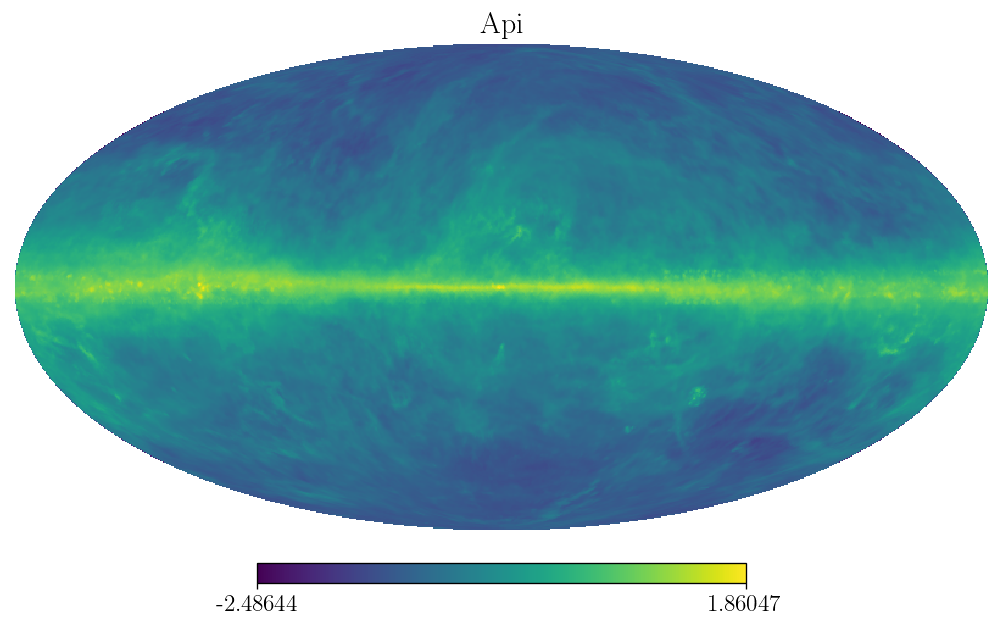

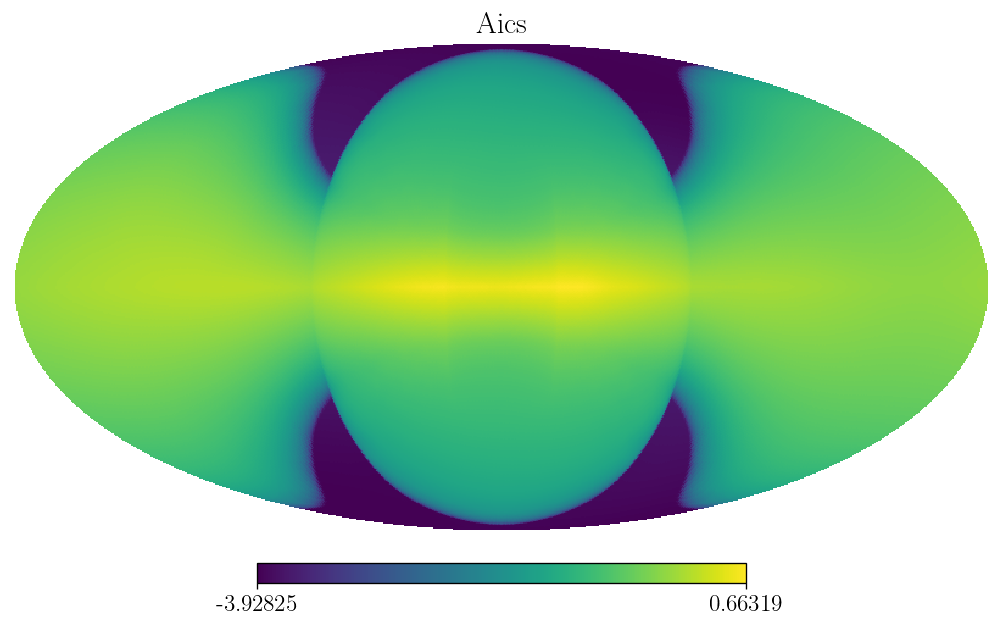

In [45]:
hp.mollview(np.log10(pib_temp_hp), title="Api")
hp.mollview(np.log10(ics_temp_hp), title="Aics")

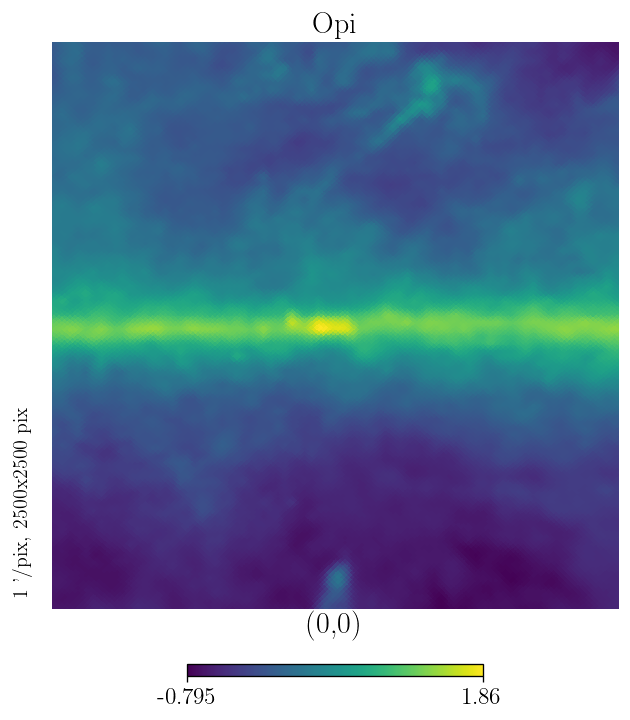

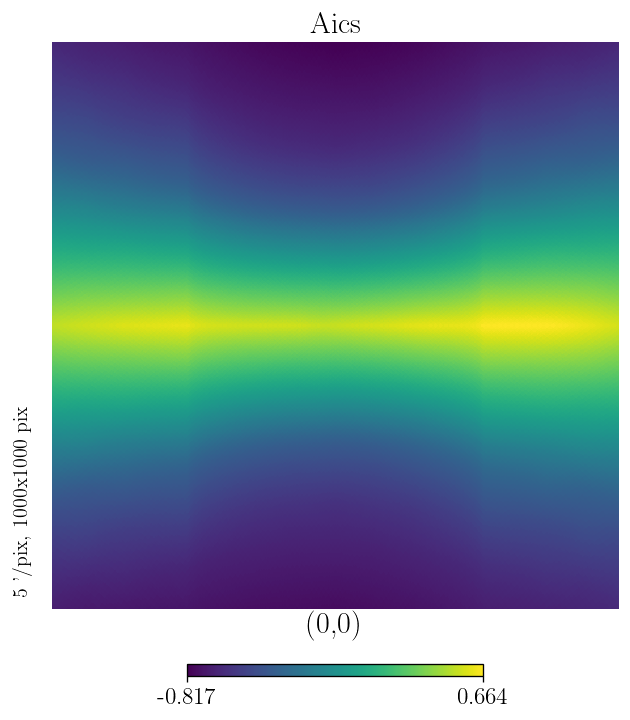

In [47]:
hp.gnomview(np.log10(pib_temp_hp), rot=[0, 0], xsize=1000, ysize=1000, title="Api", reso=5)
hp.gnomview(np.log10(ics_temp_hp), rot=[0, 0], xsize=1000, ysize=1000, title="Aics", reso=5)

In [28]:
pib_temp.shape

(196608,)

In [29]:
pib_temp_m = np.array([pib_temp[n][~mask_roi] for n in range(40)])
pib_means = pib_temp_m.mean(axis=1)
ics_temp_m = np.array([ics_temp[n][~mask_roi] for n in range(40)])
ics_means = ics_temp_m.mean(axis=1)

IndexError: invalid index to scalar variable.

In [96]:
ebins = np.logspace(np.log10(0.2), np.log10(2000), 40)

Text(0.5, 1.0, 'Aics')

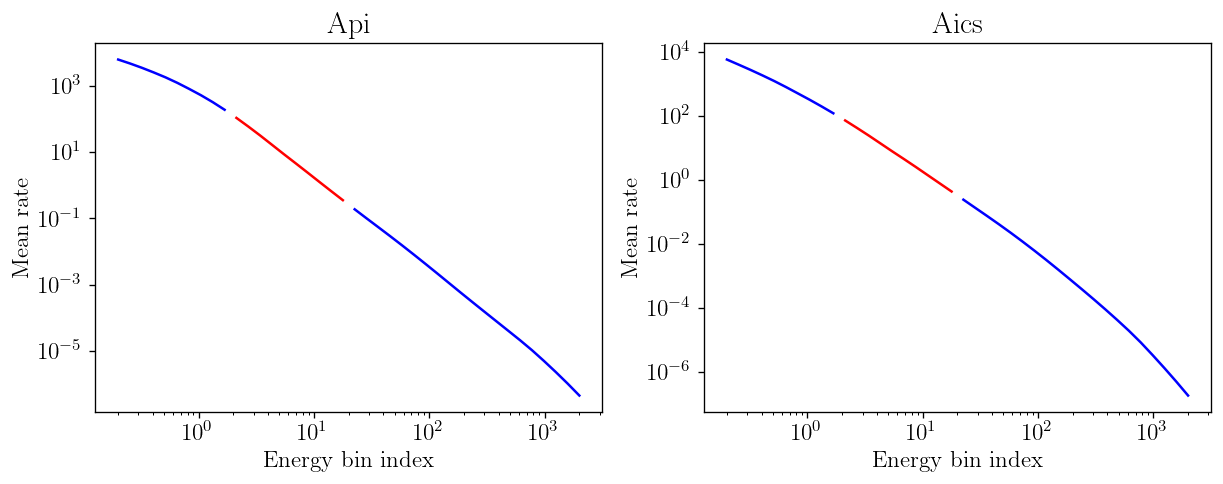

In [97]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(121)

ax.loglog(ebins[:10], pib_means[:10], color = 'blue')
ax.loglog(ebins[20:], pib_means[20:], color = 'blue')
ax.loglog(ebins[10:20], pib_means[10:20], color = 'red')

ax.set_xlabel("Energy bin index")
ax.set_ylabel("Mean rate")
ax.set_title("Api")

ax = fig.add_subplot(122)

ax.loglog(ebins[:10], ics_means[:10], color = 'blue')
ax.loglog(ebins[20:], ics_means[20:], color = 'blue')
ax.loglog(ebins[10:20], ics_means[10:20], color = 'red')

ax.set_xlabel("Energy bin index")
ax.set_ylabel("Mean rate")
ax.set_title("Aics")


In [98]:
# load 2 - 20 GeV binned templates
pib_temp_s = pib_temp[10:20]
ics_temp_s = ics_temp[10:20]

# sum templates
pib_temp_sum = pib_temp_s.sum(axis=0)
ics_temp_sum = ics_temp_s.sum(axis=0)

# artificially increase the number of bins
pib_temp_fin = np.tile(pib_temp_sum, (40,1))
ics_temp_fin = np.tile(ics_temp_sum, (40,1))

In [99]:
# save summed templates
np.save("../data/fermi_data_573w/ebin_128/ccwasumpibrem-ultracleanveto-bestpsf.npy", pib_temp_fin)
np.save("../data/fermi_data_573w/ebin_128/ccwasumics-ultracleanveto-bestpsf.npy", ics_temp_fin)

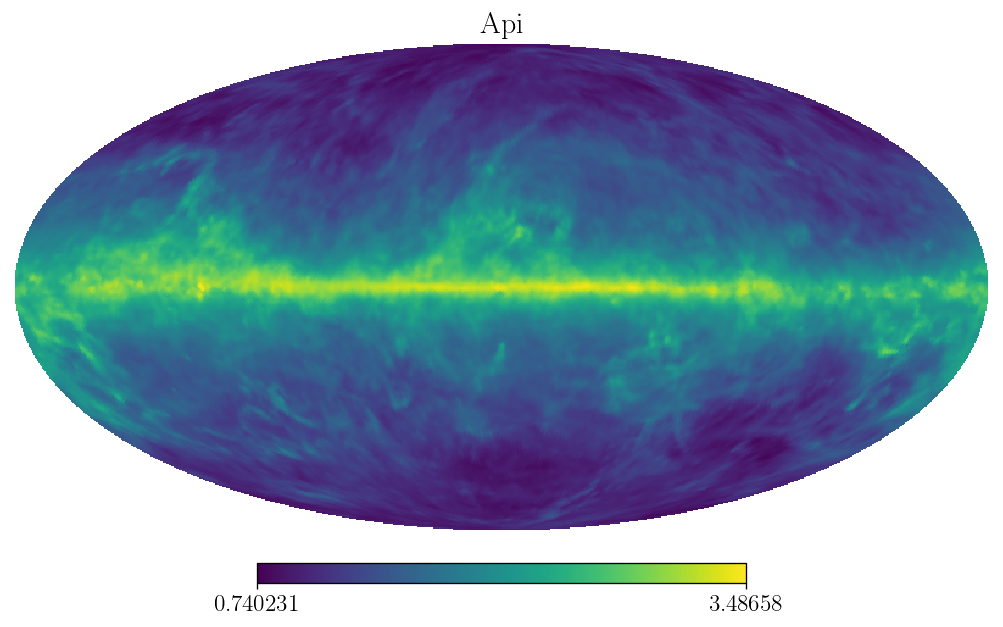

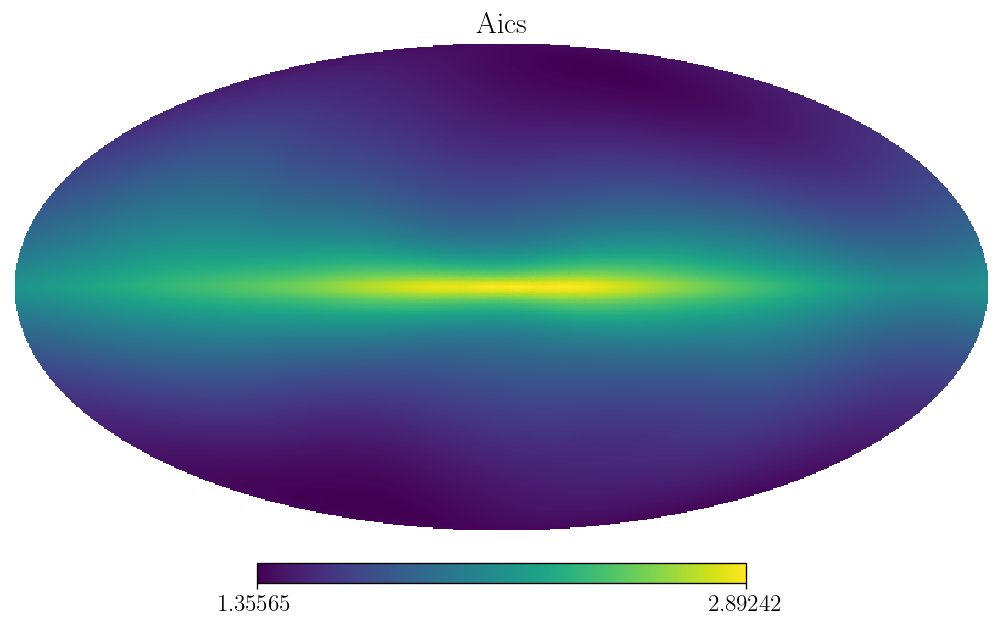

In [100]:
ie = 10
hp.mollview(np.log10(pib_temp_sum), title="Api")
hp.mollview(np.log10(ics_temp_sum), title="Aics")